In [1]:
import os
#os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

os.environ['TF_USE_LEGACY_KERAS'] = '1';

In [3]:
input_default_json_conf_file='fcnn_emotion4_training_default.json';

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime
import json

In [5]:
import sys
sys.path.append('../library');

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
## Load json conf json file
fd = open(os.path.join('./',input_default_json_conf_file));
DATA = json.load(fd);
fd.close()

# Variable globales

In [8]:
## Seed for the random variables
seed_number=0;

## Dataset 
dataset_base_dir    = DATA['dataset_train_base_dir'];
dataset_labels_file = DATA['dataset_train_labels_file'];

dataset_base_test_dir    = DATA['dataset_test_base_dir'];
dataset_labels_test_file = DATA['dataset_test_labels_file'];

dataset_name        = DATA['dataset_name'];

## Training hyperparameters
EPOCAS     = DATA["epochs"];
BATCH_SIZE = DATA["batch_size"];


## Output
output_base_dir = DATA["output_base_dir"];

patience=max(10,int(EPOCAS/5));
NCOD=15;


# Parametros de entrada

In [9]:
for n in range(len(sys.argv)):
    if sys.argv[n]=='--dataset-train-dir':
        dataset_base_dir=sys.argv[n+1];
    elif sys.argv[n]=='--dataset-train-file':
        dataset_labels_file=sys.argv[n+1];
    elif sys.argv[n]=='--dataset-test-dir':
        dataset_base_test_dir=sys.argv[n+1];
    elif sys.argv[n]=='--dataset-test-file':
        dataset_labels_test_file=sys.argv[n+1];
    elif sys.argv[n]=='--dataset-name':
        dataset_name=sys.argv[n+1];
    elif sys.argv[n]=='--epochs':
        EPOCAS=int(sys.argv[n+1]);
    elif sys.argv[n]=='--batch-size':
        BATCH_SIZE=int(sys.argv[n+1]);
    elif sys.argv[n]=='--ncod':
        NCOD=int(sys.argv[n+1]);
    elif sys.argv[n]=='--patience':
        patience=int(sys.argv[n+1]);
    elif sys.argv[n]=='--seed':
        seed_number=int(sys.argv[n+1]);
    elif sys.argv[n]=='--output-dir':
        output_base_dir=sys.argv[n+1];
        
print('        dataset_base_dir:',dataset_base_dir)
print('     dataset_labels_file:',dataset_labels_file)
print('   dataset_base_test_dir:',dataset_base_test_dir)
print('dataset_labels_test_file:',dataset_labels_test_file)
print('            dataset_name:',dataset_name)
print('                  EPOCAS:',EPOCAS)
print('              BATCH_SIZE:',BATCH_SIZE)
print('                    NCOD:',NCOD)
print('                patience:',patience)
print('             seed_number:',seed_number)
print('         output_base_dir:',output_base_dir)

        dataset_base_dir: /media/fernando/Expansion/DATASET/TESE/BER/BER2024/BER2024-FUSION/ber2024-source/efficientnet_b3_efficientnet_b3_ncod20
     dataset_labels_file: train.csv
   dataset_base_test_dir: /media/fernando/Expansion/DATASET/TESE/BER/BER2024/BER2024-FUSION/ber2024-source/efficientnet_b3_efficientnet_b3_ncod20
dataset_labels_test_file: test.csv
            dataset_name: ber2024-fusion
                  EPOCAS: 100
              BATCH_SIZE: 2048
                    NCOD: 15
                patience: 20
             seed_number: 0
         output_base_dir: /media/fernando/Expansion/OUTPUTS/DOCTORADO2/fcnn_emotion4_fusion_1


# Set seed of random variables


In [10]:
np.random.seed(seed_number)
tf.keras.utils.set_random_seed(seed_number);

# Loading data of dataset

In [11]:
# Load filenames and labels
train_val_df = pd.read_csv(os.path.join(dataset_base_dir,dataset_labels_file));
#print(train_val_df)

# Setting labels
Y = train_val_df[['label']];
L=np.shape(Y)[0];

# Load test filenames and labels
test_df = pd.read_csv(os.path.join(dataset_base_test_dir,dataset_labels_test_file));

print('\n\ntest_df')
print(test_df)




test_df
             d0        d1        d2        d3            d4            d5  \
0      0.000686  0.998839  0.000349  0.000126  1.989638e-05  9.997572e-01   
1      0.999747  0.000154  0.000078  0.000022  9.999405e-01  5.823886e-05   
2      0.000036  0.000102  0.000191  0.999670  5.370393e-07  1.223157e-06   
3      0.007865  0.991319  0.000236  0.000579  5.689665e-02  9.430852e-01   
4      0.000047  0.000282  0.000154  0.999517  6.336613e-06  7.395937e-05   
...         ...       ...       ...       ...           ...           ...   
16653  0.000441  0.999499  0.000023  0.000037  7.283359e-05  9.999247e-01   
16654  0.006311  0.993072  0.000470  0.000147  2.958973e-03  9.970395e-01   
16655  0.000197  0.000046  0.999420  0.000337  2.487195e-05  7.110825e-07   
16656  0.198577  0.799782  0.001604  0.000037  6.360198e-02  9.363549e-01   
16657  0.000017  0.000121  0.000156  0.999707  9.749557e-03  2.710924e-02   

                 d6            d7        d8        d9       d10  

# Setting the cross-validation split


In [12]:
from sklearn.model_selection import train_test_split

training_df, validation_df = train_test_split(train_val_df, test_size=0.2,shuffle=True, stratify=Y)

print('\n\ntraining_df')
print(training_df);


print('\n\nvalidation_df')
print(validation_df)



training_df
             d0        d1        d2        d3        d4            d5  \
17428  0.023349  0.975039  0.001465  0.000147  0.000480  9.995130e-01   
7726   0.004407  0.000271  0.993413  0.001908  0.072003  9.962386e-04   
12214  0.998762  0.000832  0.000368  0.000038  0.000788  4.939562e-03   
19469  0.000169  0.000054  0.997674  0.002102  0.000023  2.384938e-08   
13030  0.000195  0.000050  0.996027  0.003728  0.000011  3.453166e-07   
...         ...       ...       ...       ...       ...           ...   
11949  0.000157  0.000058  0.998835  0.000949  0.000011  8.207031e-07   
14841  0.000213  0.999638  0.000069  0.000080  0.000025  9.999744e-01   
21853  0.000029  0.000114  0.000054  0.999802  0.000006  1.854480e-04   
15222  0.000196  0.000049  0.996096  0.003659  0.000160  3.900910e-05   
57     0.000195  0.000049  0.996158  0.003598  0.000002  1.026813e-07   

                 d6            d7        d8        d9       d10       d11  \
17428  4.485263e-10  6.916557e-0

# Creating output directory

In [13]:
output_dir = os.path.join(output_base_dir,dataset_name,'training_validation_holdout','cls_ncod'+str(NCOD));

os.makedirs(output_base_dir,exist_ok = True);

os.makedirs(output_dir,exist_ok = True);

# Data augmentation configuration

In [14]:

training_data_array   = training_df.iloc[:,0:12].values;
training_y_label = training_df.iloc[:,12].values;

validation_data_array = validation_df.iloc[:,0:12].values;
validation_y_label = validation_df.iloc[:,12].values;

test_data_array = test_df.iloc[:,0:12].values;
test_y_label = test_df.iloc[:,12].values;

print('train:',training_data_array.shape, training_y_label.shape)
print('  val:',validation_data_array.shape, validation_y_label.shape)
print(' test:',test_data_array.shape, test_y_label.shape)

train: (21567, 12) (21567,)
  val: (5392, 12) (5392,)
 test: (16658, 12) (16658,)


In [15]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()

training_y   = label_encoder.fit_transform(training_y_label)
validation_y = label_encoder.fit_transform(validation_y_label)
test_y       = label_encoder.fit_transform(test_y_label)

training_y_categorical   = to_categorical(training_y)
validation_y_categorical = to_categorical(validation_y)
test_y_categorical       = to_categorical(test_y)


print('train:',training_data_array.shape,training_y_categorical.shape)
print('  val:',validation_data_array.shape,validation_y_categorical.shape)
print(' test:',test_data_array.shape,test_y_categorical.shape)


train: (21567, 12) (21567, 4)
  val: (5392, 12) (5392, 4)
 test: (16658, 12) (16658, 4)


# Create new model

In [16]:
import FusionEmotion4Lib.lib_model as mpp

model = mpp.create_model(  load_weights=False,
                           file_of_weight='',
                           ncod=NCOD);

print('input_shape',model.input_shape)
print('output_shape',model.output_shape)
print('')

model.summary()

mpp.save_model_parameters(model, os.path.join(output_dir,'parameters_stats.m'));

input_shape (None, 12)
output_shape (None, 4)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 91)                1183      
                                                                 
 dense_1 (Dense)             (None, 31)                2852      
                                                                 
 dense_2 (Dense)             (None, 15)                480       
                                                                 
 dense_3 (Dense)             (None, 4)                 64        
                                                                 
Total params: 4579 (17.89 KB)
Trainable params: 4579 (17.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-08-08 02:52:39.687084: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-08 02:52:39.687289: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-08 02:52:39.687427: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [17]:
# COMPILE NEW MODEL
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['categorical_accuracy'])

# CREATE CALLBACKS
best_model_file=os.path.join(output_dir,'model_ncod'+str(NCOD)+'.h5');
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_file, 
                                                save_weights_only=True,
                                                monitor='val_loss', 
                                                save_best_only=True, 
                                                verbose=1);

# Definindo o callback EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(  monitor='val_loss', 
                                                    patience=patience,  
                                                    verbose=1, 
                                                    restore_best_weights=False);

log_dir = os.path.join(output_dir,"logs","fit",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"));
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [18]:
# FIT THE MODEL
history = model.fit(training_data_array,training_y_categorical,
                    epochs=EPOCAS,
                    batch_size=BATCH_SIZE,
                    validation_data=(validation_data_array,validation_y_categorical),
                    callbacks=[checkpoint,early_stopping,tensorboard_callback],
                    verbose=1
                   );

Epoch 1/100


I0000 00:00:1723096369.982750   31908 service.cc:145] XLA service 0x7d605876d4f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723096369.982783   31908 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce MX150, Compute Capability 6.1
2024-08-08 02:52:49.988483: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-08 02:52:50.005956: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1723096370.071090   31908 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


674/674 [==============================] - ETA: 0s - loss: 0.1431 - categorical_accuracy: 0.9633
Epoch 1: val_loss improved from inf to 0.07262, saving model to /media/fernando/Expansion/OUTPUTS/DOCTORADO2/fcnn_emotion4_fusion_1/ber2024-fusion/training_validation_holdout/cls_ncod15/model_ncod15.h5
674/674 [==============================] - 14s 6ms/step - loss: 0.1431 - categorical_accuracy: 0.9633 - val_loss: 0.0726 - val_categorical_accuracy: 0.9798
Epoch 2/100
669/674 [============================>.] - ETA: 0s - loss: 0.0571 - categorical_accuracy: 0.9820
Epoch 2: val_loss improved from 0.07262 to 0.07215, saving model to /media/fernando/Expansion/OUTPUTS/DOCTORADO2/fcnn_emotion4_fusion_1/ber2024-fusion/training_validation_holdout/cls_ncod15/model_ncod15.h5
674/674 [==============================] - 4s 6ms/step - loss: 0.0579 - categorical_accuracy: 0.9819 - val_loss: 0.0721 - val_categorical_accuracy: 0.9802
Epoch 3/100
668/674 [============================>.] - ETA: 0s - loss: 0.05

max_val_acc 0.9821958541870117


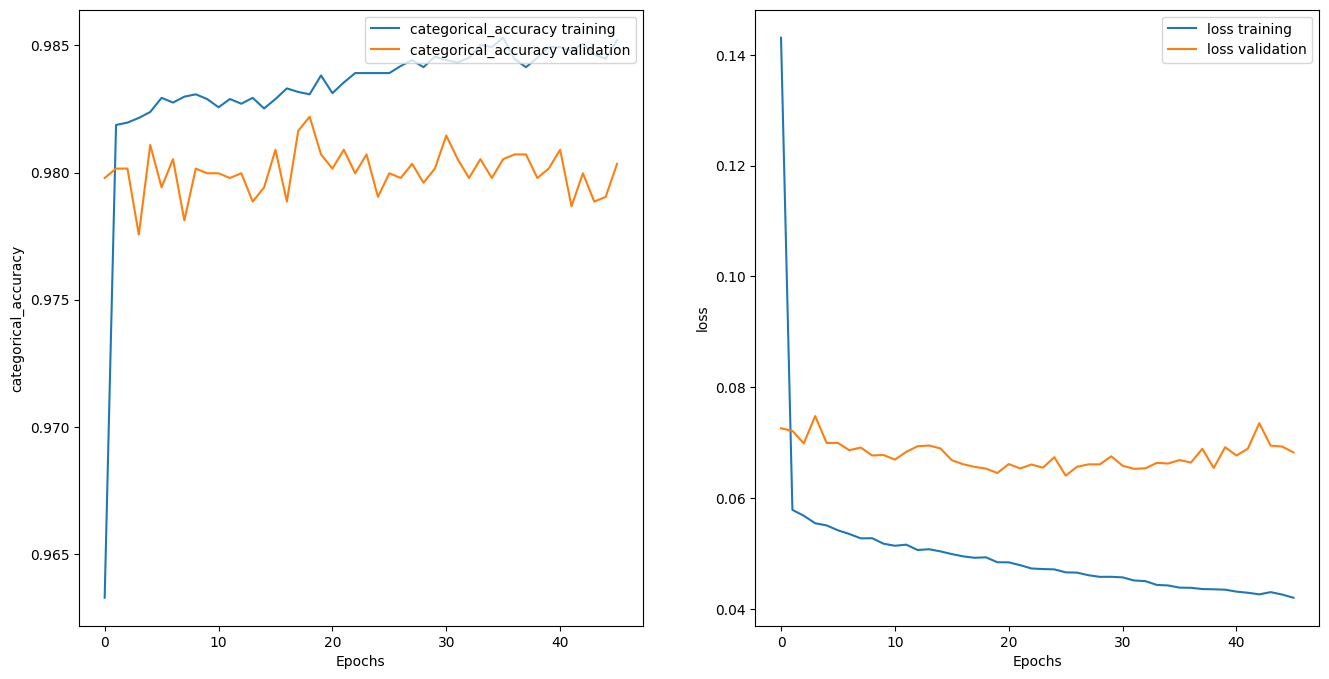

In [19]:
mpp.save_model_history(history,
                       os.path.join(output_dir,"historical.csv"),
                       show=False,
                       labels=['categorical_accuracy','loss']);

In [20]:
# LOAD BEST MODEL to evaluate the performance of the model
model.load_weights(best_model_file);
data_results=dict();

# Evaluate training
results = model.evaluate(training_data_array,training_y_categorical)
results = dict(zip(model.metrics_names,results))
print('training',results,"\n\n");
for key,value in results.items():
    data_results['train_'+key]=value;

# Evaluate validation
results = model.evaluate(validation_data_array,validation_y_categorical)
results = dict(zip(model.metrics_names,results))
print('validation',results,"\n\n");
for key,value in results.items():
    data_results['val_'+key]=value;

# Evaluate testing
results = model.evaluate(test_data_array,test_y_categorical)
results = dict(zip(model.metrics_names,results))
print('testing',results,"\n\n");
for key,value in results.items():
    data_results['test_'+key]=value;

data_results['number_of_parameters']=mpp.get_model_parameters(model);
data_results['ncod']=NCOD;
data_results['epochs']=EPOCAS;
data_results['patience']=patience;
data_results['seed']=seed_number;

# final all json
with open(os.path.join(output_dir,"training_data_results.json"), 'w') as f:
    json.dump(data_results, f,indent=4);

tf.keras.backend.clear_session()

674/674 [==============================] - 2s 2ms/step - loss: 0.0450 - categorical_accuracy: 0.9846
training {'loss': 0.044950153678655624, 'categorical_accuracy': 0.9845597147941589} 


169/169 [==============================] - 1s 3ms/step - loss: 0.0641 - categorical_accuracy: 0.9800
validation {'loss': 0.0640740916132927, 'categorical_accuracy': 0.9799703359603882} 


521/521 [==============================] - 2s 3ms/step - loss: 0.0991 - categorical_accuracy: 0.9693
testing {'loss': 0.09909793734550476, 'categorical_accuracy': 0.9693240523338318} 




521/521 [==============================] - 1s 1ms/step
Categorical accuracy: 0.9693240485052227
{
    "negative": {
        "precision": 0.9567099567099567,
        "recall": 0.9455669122890421,
        "f1-score": 0.9511057979677227,
        "support": 4207.0
    },
    "neutral": {
        "precision": 0.9588916647740177,
        "recall": 0.9491906474820144,
        "f1-score": 0.9540164953112643,
        "support": 4448.0
    },
    "pain": {
        "precision": 0.9740985271711529,
        "recall": 0.9930106135128138,
        "f1-score": 0.9834636585053198,
        "support": 3863.0
    },
    "positive": {
        "precision": 0.9884587641259919,
        "recall": 0.9929951690821256,
        "f1-score": 0.9907217737076757,
        "support": 4140.0
    },
    "accuracy": 0.9693240485052227,
    "macro avg": {
        "precision": 0.9695397281952798,
        "recall": 0.970190835591499,
        "f1-score": 0.9698269313729955,
        "support": 16658.0
    },
    "weighted avg": 

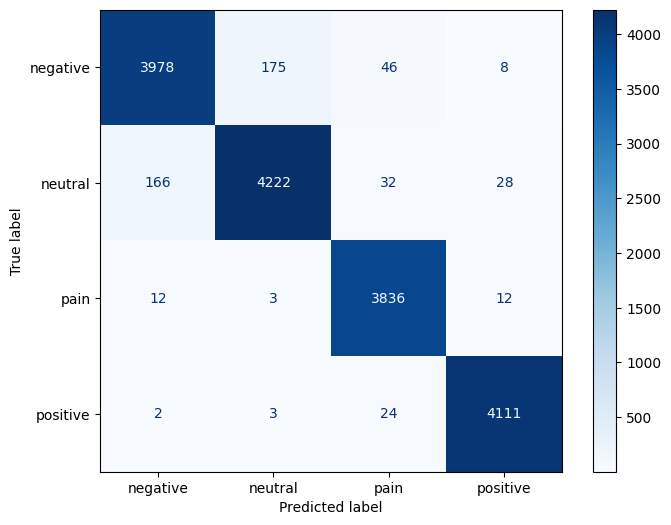

In [21]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

target_names = ['negative','neutral','pain','positive'];

# Predict
Y_pred = model.predict(test_data_array,verbose=1);
y_pred = np.argmax(Y_pred, axis=1);

# Calculate accuracy
categorical_accuracy = np.mean(test_y == y_pred);
print(f'Categorical accuracy: {categorical_accuracy}');

# Confusion matrix
CM=confusion_matrix(test_y, y_pred);

fname=os.path.join(output_dir,"confusion_matrix.eps");
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=target_names)
disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.savefig(fname)

cm_dict=dict();
cm_dict['matrix']=CM.tolist();
cm_dict['label']=target_names;
# final all json
with open(os.path.join(output_dir,"confusion_matrix.json"), 'w') as f:
    json.dump(cm_dict, f,indent=4);
    f.close()

# Classification report
fname=os.path.join(output_dir,"classification_report.json")
dict_dat=classification_report(test_y, y_pred, target_names=target_names,output_dict=True);
print(json.dumps(dict_dat, indent=4))
with open(fname, 'w') as f: 
    json.dump(dict_dat, f,indent=4);
    f.close()